# 13. CNN with CIFAR10

In [1]:
import torch
import torch.nn as nn

import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import os

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 13.1 Prepare Data

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))])

batch_size = 125

cifar10_train = dsets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)
cifar10_test  = dsets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=batch_size,
                                         shuffle=True, num_workers=1)

test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=5,
                                        shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

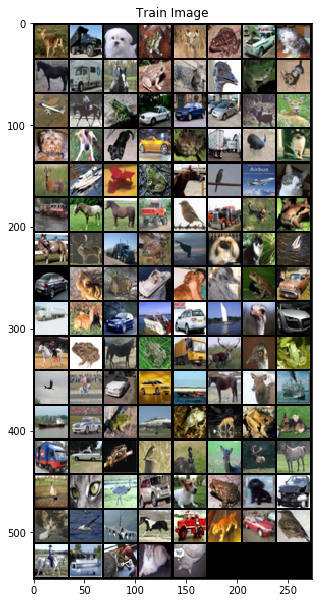

In [5]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

In [6]:
images.size()

torch.Size([125, 3, 32, 32])

## 13.2 Define Model

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, 5),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, 5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(64 * 5 * 5, 100),
            nn.ReLU(),
            nn.Linear(100, 10)              
        )
        
    def forward(self, x):
        out = self.conv_layer(x)
        out = out.view(-1, 64*5*5)
        out = self.fc_layer(out)
        
        return out
    
model = CNN().cuda()

In [8]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

## 13.3 Train Model

In [9]:
num_epochs = 10

In [10]:
for epoch in range(num_epochs):

    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = batch_images.cuda()
        Y = batch_labels.cuda()

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(cifar10_train)//batch_size, cost.item()))

Epoch [1/10], lter [100/400], Loss: 1.4064
Epoch [1/10], lter [200/400], Loss: 1.2597
Epoch [1/10], lter [300/400], Loss: 1.1591
Epoch [1/10], lter [400/400], Loss: 0.9978
Epoch [2/10], lter [100/400], Loss: 1.0004
Epoch [2/10], lter [200/400], Loss: 1.0532
Epoch [2/10], lter [300/400], Loss: 0.9631
Epoch [2/10], lter [400/400], Loss: 0.8711
Epoch [3/10], lter [100/400], Loss: 0.9134
Epoch [3/10], lter [200/400], Loss: 0.8040
Epoch [3/10], lter [300/400], Loss: 0.8302
Epoch [3/10], lter [400/400], Loss: 0.7926
Epoch [4/10], lter [100/400], Loss: 0.7847
Epoch [4/10], lter [200/400], Loss: 0.8740
Epoch [4/10], lter [300/400], Loss: 0.8300
Epoch [4/10], lter [400/400], Loss: 0.8293
Epoch [5/10], lter [100/400], Loss: 0.7497
Epoch [5/10], lter [200/400], Loss: 0.8880
Epoch [5/10], lter [300/400], Loss: 0.7459
Epoch [5/10], lter [400/400], Loss: 0.7108
Epoch [6/10], lter [100/400], Loss: 0.6303
Epoch [6/10], lter [200/400], Loss: 0.5801
Epoch [6/10], lter [300/400], Loss: 0.7309
Epoch [6/10

## 13.4 Test Model

In [11]:
model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

Accuracy of test images: 73.790000 %


Predicted:    cat  ship  ship plane  frog


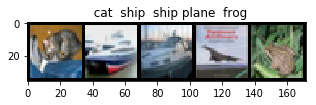

In [12]:
images, labels = iter(test_loader).next()

outputs = model(images.cuda())

_, predicted = torch.max(outputs.data, 1)
    
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(5)))

title = (' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images, normalize=True), title)